## Big Data - Sagar Agarwal

### Setting up the Dataset and Variable

Importing revelant packages

In [ ]:
import pandas as pd
import wrds
import time
from fire_pytools.portools.sort_portfolios import *
from fire_pytools.portools.find_breakpoints import *


Creating relevant breakpoint variables

In [73]:
char_breakpoints = {'me': [0.5],
                    'beme': [0.3, 0.7],
                    'opbe': [0.3, 0.7],
                    'inv': [0.3, 0.7]}
weightvar = 'melag'
retvar = 'retadj'
rankvar = 'rankyear'

In [8]:
def calculate_cumulative_returns(mdata, tt, min_periods): #TODO: to be completed
    """
    Calculate past returns for momentum stratagy

    Parameters:
    ------------
    mdata: data frame
        crsp monthly data with cols permno, date as index.
    tt: int
        number of periods to cumulate retuns
    min_periods: int
        minimum number of periods. Default tt/2
    """
    start_time = time.time()

    required_cols = ['retadj', 'ret']

    assert set(required_cols).issubset(mdata.columns), "Required columns: {}.".format(', '.join(required_cols))

    df = mdata[required_cols].copy()
    df['retadj'] = df['retadj']+1
    df['ret'] = df['ret'].notnull()

    df.reset_index(level=0, inplace=True)

    # Cumulative Return (adjusted) in 11 months
    cret = df.groupby('permno')['retadj'].rolling(window=tt, min_periods=1).apply(np.prod)
    nona_count = df.groupby('permno')['ret'].rolling(window=tt, min_periods=1).apply(np.sum)
    
    cret = cret-1
    cret = cret.to_frame('ret' + str(tt))
    cret[nona_count <= min_periods] = np.nan

    print("Time to calculate %d months past returns: %s seconds" % (tt, str(round(time.time() - start_time, 2))))

    return cret
db = wrds.Connection(wrds_username='sagar520')  # make sure to configure wrds connector before hand.


In [ ]:
### Get all data
mdata = pd.read_pickle('stock_monthly.pkl')
adata = pd.read_pickle('stock_annual.pkl')

adata.rename(columns= {'mesum_june':'me', 'inv_qvkey':'inv'}, inplace = True)
mdata.rename(columns= {weightvar:'weightvar', retvar:'retvar'}, inplace = True)
## Risk-free Rate
mdata['retadj'] = mdata['retvar']
mdata['ret_11_1'] = calculate_cumulative_returns(mdata, 11, 6)

In [ ]:
query = "SELECT caldt as date, t30ret as rf FROM crspq.mcti"
rf = db.raw_sql(query, date_cols=['date'])
rf.set_index('date', inplace=True)

Checking our dataset

In [71]:
summary=pd.concat([
mdata.groupby('rankyear')['ret_11_1'].agg(lambda x:x.isnull().sum()),
mdata.reset_index().groupby('rankyear')['permno'].agg(lambda x:x.nunique()),
mdata.groupby('rankyear')['ret_11_1'].min(),
mdata.groupby('rankyear')['ret_11_1'].mean(),
mdata.groupby('rankyear')['ret_11_1'].max()],axis=1)
summary.columns=['nan Returns', 'Unique permnos', 'Min Ret', 'Mean Ret', 'Max Ret']
print(summary)

          nan Returns  Unique permnos   Min Ret  Mean Ret     Max Ret
rankyear                                                             
1925.0         3753.0             551       NaN       NaN         NaN
1926.0         2893.0             587 -1.000000  0.122527    3.457143
1927.0         1127.0             632 -1.000000  0.289162   10.000000
1928.0         1354.0             719 -0.696970  0.346312   16.200000
1929.0         1997.0             786 -0.958042 -0.138759    5.609375
1930.0         1295.0             772 -1.000000 -0.364192    2.414417
1931.0         1057.0             758 -1.000000 -0.488757    2.258761
1932.0          698.0             730 -1.000000  0.375490   18.500001
1933.0          680.0             723 -0.933333  0.947515   44.769231
1934.0          527.0             732 -1.000000 -0.040689    5.333333
1935.0          713.0             758 -0.760000  0.632744   12.363636
1936.0          768.0             787 -0.925000  0.411299    8.300741
1937.0          716.

In [10]:
mdata.columns

Index(['date', 'dlret', 'dlretx', 'exchcd', 'naics', 'permco', 'prc', 'ret',
       'shrcd', 'shrout', 'siccd', 'ticker', 'rankyear', 'retvar', 'me',
       'mesum_permco', 'mesum', 'weightvar', 'retadj', 'ret_11_1'],
      dtype='object')

In [72]:
adata.head()

gvkey   datadate                          conm   fyear   fyr      at  \
0     NaN        NaT                           NaN     NaN   NaN     NaN   
1  013007 1986-10-31  OPTIMUM MANUFACTURING  -CL A  1986.0  10.0   2.115   
2     NaN        NaT                           NaN     NaN   NaN     NaN   
3  012994 1986-06-30               GAS NATURAL INC  1986.0   6.0  12.242   
4  012994 1987-06-30               GAS NATURAL INC  1987.0   6.0  11.771   

    capx    ceq    cogs    dlc     ...            mejune  exchcd  shrcd  \
0    NaN    NaN     NaN    NaN     ...       11734.59375     3.0   10.0   
1  0.240  0.418   0.511  0.968     ...               NaN     3.0   10.0   
2    NaN    NaN     NaN    NaN     ...        6033.12500     3.0   11.0   
3  0.551  5.432  19.565  0.343     ...        5822.12500     3.0   11.0   
4  0.513  5.369  15.538  0.377     ...        6200.00000     3.0   11.0   

   ticker   siccd        me        medec    mesum_dec      beme  sich_filled  
0   OMFGA  3990.0       NaN          NaN          NaN       NaN       3990.0  
1   OMFGA  3990.0       NaN  1981.546875  1981.546875  0.000211       3990.0  
2    GFGC  4920.0       NaN          NaN          NaN       NaN       4920.0  
3    GFGC  4920.0  5822.125  6937.000000  6937.000000  0.001014       4920.0  
4    GFGC  4920.0  6200.000  5828.000000  5828.000000  0.001208       4924.0  

[5 rows x 49 columns]

In [12]:
rf.head(5)

rf
date                
1925-12-31       NaN
1926-01-30  0.002951
1926-02-27  0.002768
1926-03-31  0.002778
1926-04-30  0.003072

Putting filters of SHRCH, Exchange, valid returns, Market Equity>0 and no null values in variable of interest

In [13]:
#####valid returns
rdata =  mdata[mdata.retvar.notnull()]

In [14]:
### shrd check
sort_data = adata[adata.shrcd.isin([10,11])].copy()

In [15]:
###exch check
sort_data = sort_data[sort_data.exchcd.isin([1,2,3])]

In [ ]:
######### filter Date

In [74]:
sortvars = [*char_breakpoints]
bp_filters = [None] * len(sortvars)
bp_filters = dict(zip(sortvars, bp_filters))
sample_filters = [None] * len(sortvars)
sample_filters = dict(zip(sortvars, sample_filters))

for sortvar in sortvars:
    bp_filters[sortvar] = ((sort_data[sortvar].notnull()))
    sample_filters[sortvar] = ((sort_data.me > 0) & (sort_data.mesum_dec > 0) &(sort_data[sortvar].notnull()))

### Calculating Breakpounts

In [75]:
bps = [None] * len(sortvars)
bps = dict(zip(sortvars, bps))

for sortvar in sortvars:
    bps[sortvar] = find_breakpoints(sort_data[bp_filters[sortvar]],
                                      quantiles={sortvar: char_breakpoints[sortvar]},
                                      id_variables=[rankvar, 'permno', 'exchcd'], exch_cd = [1])

NYSE breakpoints were calculated for me.
NYSE breakpoints were calculated for beme.
NYSE breakpoints were calculated for opbe.
NYSE breakpoints were calculated for inv.


### Sort Portfolio

Sorting the dataset baset on the breakpoints calculated

In [76]:
ports = [None] * len(sortvars)
ports = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    ports[sortvar] = sort_portfolios(sort_data[sample_filters[sortvar]],
                                       quantiles={sortvar: char_breakpoints[sortvar]},
                                       id_variables=[rankvar, 'permno', 'exchcd'],
                                       breakpoints={sortvar: bps[sortvar]})

Stocks were sorted according to breakpoints, starting in 1926.0
Stocks were sorted according to breakpoints, starting in 1926.0
Stocks were sorted according to breakpoints, starting in 1951.0
Stocks were sorted according to breakpoints, starting in 1952.0


### Merge Portfolio

Merging the sorted dataset to monthly filtered data

In [77]:
mergedp = ports['me'].copy()
for sortvar in sortvars[1:]:
    mergedp = mergedp.merge(ports[sortvar], on=['permno', rankvar], how='outer')

port_ret = pd.merge(mergedp, rdata, on=['rankyear', 'permno'])
idx = pd.IndexSlice

In [67]:
def wavg(group, avg_name, weight_name):
    """ Source: http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    Calculates weighted average of a column in a dataset based on weight column
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [78]:
port_ret.head()

rankyear   permno meportfolio bemeportfolio opbeportfolio invportfolio  \
0    1926.0  10006.0         me2         beme2           NaN          NaN   
1    1926.0  10006.0         me2         beme2           NaN          NaN   
2    1926.0  10006.0         me2         beme2           NaN          NaN   
3    1926.0  10006.0         me2         beme2           NaN          NaN   
4    1926.0  10006.0         me2         beme2           NaN          NaN   

        date  dlret  dlretx  exchcd    ...    shrout   siccd  ticker  \
0 1926-08-31    NaN     NaN     1.0    ...     600.0  3740.0    None   
1 1926-09-30    NaN     NaN     1.0    ...     600.0  3740.0    None   
2 1926-10-30    NaN     NaN     1.0    ...     600.0  3740.0    None   
3 1926-11-30    NaN     NaN     1.0    ...     600.0  3740.0    None   
4 1926-12-31    NaN     NaN     1.0    ...     600.0  3740.0    None   

     retvar     me  mesum_permco  mesum weightvar    retadj  ret_11_1  
0  0.020202  60.60         60.60    NaN     59.40  0.020202       NaN  
1  0.009901  60.30         60.30    NaN     60.60  0.009901       NaN  
2 -0.014925  59.40         59.40    NaN     60.30 -0.014925       NaN  
3  0.047980  62.25         62.25    NaN     59.40  0.047980       NaN  
4 -0.007229  60.90         60.90    NaN     62.25 -0.007229       NaN  

[5 rows x 25 columns]

### Factor Calculations

Calculating the factors based on the Fama French website.

In [80]:
#### Factors
# BEME
charvars = ['me','beme']
beme_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
beme_ret = beme_ret.unstack(level=[1,2])
beme_ret['HML'] = beme_ret.loc[:,idx[:,'beme3']].mean(axis=1) - beme_ret.loc[:,idx[:,'beme1']].mean(axis=1)
beme_ret.columns =[''.join(col).strip() for col in beme_ret.columns.values]

# INV
charvars = ['me','inv']
inv_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
inv_ret = inv_ret.unstack(level=[1,2])
inv_ret['CMA'] = inv_ret.loc[:,idx[:,'inv1']].mean(axis=1) - inv_ret.loc[:,idx[:,'inv3']].mean(axis=1)
inv_ret.columns =[''.join(col).strip() for col in inv_ret.columns.values]

# OP
charvars = ['me','opbe']
op_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
op_ret = op_ret.unstack(level=[1,2])
op_ret['RMW'] = op_ret.loc[:,idx[:,'opbe3']].mean(axis=1) - op_ret.loc[:,idx[:,'opbe1']].mean(axis=1)
op_ret.columns =[''.join(col).strip() for col in op_ret.columns.values]

# SMB
charvars = ['inv', 'me']
smbinv_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
smbinv_ret = smbinv_ret.unstack(level=[1,2])
smbinv_ret['sbm_i'] = smbinv_ret.loc[:,idx[:,'me1']].mean(axis=1) - smbinv_ret.loc[:,idx[:,'me2']].mean(axis=1)
smbinv_ret.columns =[''.join(col).strip() for col in smbinv_ret.columns.values]

charvars = ['opbe', 'me']
smbop_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
smbop_ret = smbop_ret.unstack(level=[1,2])
smbop_ret['sbm_o'] = smbop_ret.loc[:,idx[:,'me1']].mean(axis=1) - smbop_ret.loc[:,idx[:,'me2']].mean(axis=1)
smbop_ret.columns =[''.join(col).strip() for col in smbop_ret.columns.values]

charvars = ['beme', 'me']
smbbe_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
smbbe_ret = smbbe_ret.unstack(level=[1,2])
smbbe_ret['sbm_b'] = smbbe_ret.loc[:,idx[:,'me1']].mean(axis=1) - smbbe_ret.loc[:,idx[:,'me2']].mean(axis=1)
smbbe_ret.columns =[''.join(col).strip() for col in smbbe_ret.columns.values]

Re-calculting for Momentum factor using monthly data now

In [ ]:
### MOM
rdata =  mdata[mdata.retvar.notnull()]

msort_data = rdata[rdata.shrcd.isin([10,11])].copy()
msort_data = msort_data[msort_data.exchcd.isin([1,2,3])]
sortvars = ['ret_11_1', 'me']

bp_filters = [None] * len(sortvars)
bp_filters = dict(zip(sortvars, bp_filters))

sample_filters = [None] * len(sortvars)
sample_filters = dict(zip(sortvars, sample_filters))

for sortvar in sortvars:
    # for each sortvar we define filters according to the exchanges that should be taken into account (e.g. FF only use NYSE firms)
    # notice that the way we defined BEME or OP: NULL if BE<=0
    bp_filters[sortvar] = ((msort_data[sortvar].notnull()))
    sample_filters[sortvar] = ((msort_data.me > 0) &(msort_data[sortvar].notnull()))

bps = [None] * len(sortvars)
bps = dict(zip(sortvars, bps))

bps['ret_11_1'] = find_breakpoints(msort_data[bp_filters['ret_11_1']],
                                  quantiles={'ret_11_1': [0.3, 0.7]},
                                  id_variables=[rankvar, 'permno', 'exchcd'], exch_cd = [1])
bps['me'] = find_breakpoints(msort_data[bp_filters['me']],
                                  quantiles={'me': [0.5]},
                                  id_variables=[rankvar, 'permno', 'exchcd'], exch_cd = [1])

# Sort portfolios
ports = [None] * len(sortvars)
ports = dict(zip(sortvars, bp_filters))

# calculate the portfolio allocation for each characteristic and save them in a list
ports['me'] = sort_portfolios(msort_data[sample_filters['me']],
                                   quantiles={'me': [0.5]},
                                   id_variables=[rankvar, 'permno', 'exchcd'],
                                   breakpoints={'me': bps['me']})
ports['ret_11_1'] = sort_portfolios(msort_data[sample_filters['ret_11_1']],
                                   quantiles={'ret_11_1': [0.3, 0.7]},
                                   id_variables=[rankvar, 'permno', 'exchcd'],
                                   breakpoints={'ret_11_1': bps['ret_11_1']})

#### merge
mergedp = ports['ret_11_1'].copy()
mergedp = mergedp.merge(ports['me'], on=['permno', rankvar], how='outer')

port_ret = pd.merge(mergedp, rdata, on=['rankyear', 'permno'])
# MOM

In [26]:
port_ret.columns

Index(['rankyear', 'permno', 'ret_11_1portfolio', 'meportfolio', 'date',
       'dlret', 'dlretx', 'exchcd', 'naics', 'permco', 'prc', 'ret', 'shrcd',
       'shrout', 'siccd', 'ticker', 'retvar', 'me', 'mesum_permco', 'mesum',
       'weightvar', 'retadj', 'ret_11_1'],
      dtype='object')

In [27]:
charvars = ['me','ret_11_1']
mom_ret = port_ret.groupby(['date']+[charvar+"portfolio" for charvar in charvars]).apply(wavg, 'retvar', 'weightvar')
mom_ret = mom_ret.unstack(level=[1,2])
mom_ret['MOM'] = mom_ret.loc[:,idx[:,'ret_11_13']].mean(axis=1) - mom_ret.loc[:,idx[:,'ret_11_11']].mean(axis=1)
mom_ret.columns =[''.join(col).strip() for col in mom_ret.columns.values]

In [28]:
mom_ret.head()

me1ret_11_11  me1ret_11_12  me1ret_11_13  me2ret_11_11  \
date                                                                 
1926-07-31     -0.020925      0.015065      0.021351     -0.011135   
1926-08-31      0.004317      0.019658      0.057876     -0.021964   
1926-09-30     -0.056836     -0.017465      0.042411     -0.037951   
1926-10-30     -0.080592     -0.034132     -0.008951     -0.037103   
1926-11-30     -0.025474      0.019032      0.066030     -0.002014   

            me2ret_11_12  me2ret_11_13       MOM  
date                                              
1926-07-31      0.024782      0.070346  0.061878  
1926-08-31      0.024091      0.061590  0.068556  
1926-09-30     -0.004063      0.049135  0.093167  
1926-10-30     -0.026089     -0.031595  0.038574  
1926-11-30      0.031187      0.034546  0.064032

Merging all the factors into a file

In [81]:
fdata = pd.merge(rf, beme_ret, on=['date'])
fdata = pd.merge(fdata, op_ret, on=['date'])
fdata = pd.merge(fdata, inv_ret, on=['date'])
fdata = pd.merge(fdata, smbinv_ret, on=['date'])
fdata = pd.merge(fdata, smbop_ret, on=['date'])
fdata = pd.merge(fdata, smbbe_ret, on=['date'])
fdata['SMB'] = (fdata['sbm_i'] +fdata['sbm_o'] + fdata['sbm_b'])/3
fdata = pd.merge(fdata, mom_ret, on=['date'])

fdata_f= fdata[['rf','HML','RMW','CMA','SMB', 'MOM']]
fdata_f.head(10)

rf       HML       RMW       CMA       SMB       MOM
date                                                                  
1952-07-31  0.001501 -0.004453  0.017957 -0.003353  0.000297  0.031237
1952-08-29  0.001467 -0.001976  0.008970  0.021776  0.008258  0.037901
1952-09-30  0.001584 -0.014890  0.027065 -0.007928  0.010706  0.049394
1952-10-31  0.001252 -0.004995  0.009958  0.011773 -0.013933  0.041042
1952-11-28  0.001049  0.009834  0.019603 -0.022336 -0.001790  0.021907
1952-12-31  0.001753  0.004469  0.004163  0.014270 -0.013364  0.027830
1953-01-30  0.001620  0.012691  0.004254  0.002686  0.040734  0.016806
1953-02-27  0.001402 -0.000486  0.006507  0.003174  0.021014  0.018630
1953-03-31  0.001892 -0.008066  0.003701 -0.000763  0.001506  0.011120
1953-04-30  0.001636  0.014235 -0.000622  0.017367  0.012017  0.017594

### Comparing with Fama/French Factors

Importing FF factors from the Fama french website and setting it up to be compared to factors calculated by me.

In [82]:
ff_factors = pd.read_csv('ff_factors.csv')
import datetime
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4) 
    return next_month - datetime.timedelta(days=next_month.day)

ff_factors['date'] = ff_factors['date'].apply(lambda x: last_day_of_month(pd.to_datetime(str(x), format='%Y%m')))
ff_factors.set_index('date', inplace=True)
ff_factors = pd.merge(fdata_f, ff_factors, on=['date'])

ff_factors.head(10)

rf       HML       RMW       CMA       SMB       MOM  \
date                                                                     
1963-07-31  0.002784 -0.006864  0.003890 -0.009668 -0.005030  0.052875   
1963-09-30  0.002755  0.001554 -0.008076 -0.005564 -0.004746  0.039677   
1963-10-31  0.002919 -0.005193  0.030230 -0.025573 -0.004562  0.069641   
1963-12-31  0.003060 -0.005058  0.002530 -0.000842 -0.015796  0.046263   
1964-01-31  0.002866  0.016814  0.001523  0.005848  0.003238  0.050816   
1964-03-31  0.003298  0.032662 -0.018977  0.027860  0.018010  0.034005   
1964-04-30  0.002904 -0.003750 -0.013326 -0.027260 -0.014389  0.023767   
1964-06-30  0.003136  0.001785  0.001289  0.003304  0.001995  0.003499   
1964-07-31  0.002808  0.004524  0.000550  0.010520  0.005512  0.061148   
1964-08-31  0.002772 -0.001830 -0.001305 -0.002004  0.007230  0.038391   

            Mkt-RF  SMB_t  HML_t  RMW_t  CMA_t  RF_t  
date                                                  
1963-07-31   -0.39  -0.47  -0.83   0.66  -1.15  0.27  
1963-09-30   -1.57  -0.48   0.18  -0.76   0.24  0.27  
1963-10-31    2.53  -1.29  -0.10   2.75  -2.24  0.29  
1963-12-31    1.83  -1.89  -0.12   0.08  -0.30  0.29  
1964-01-31    2.24   0.08   1.59   0.22   1.50  0.30  
1964-03-31    1.41   1.41   3.32  -2.01   2.93  0.31  
1964-04-30    0.10  -1.52  -0.55  -1.35  -1.08  0.29  
1964-06-30    1.27   0.09   0.68  -0.42   0.14  0.30  
1964-07-31    1.74   0.53   0.68   0.14   1.84  0.30  
1964-08-31   -1.44   0.30   0.09   0.06   0.36  0.28

Sumary statistics of the dataset. 'row_t' indicates the True Fama French factor and 'row' is my factor. Also one thing to note here is that fama french has returns scaled by a 100. This is not going to effect our correlation so I dont bother dividing them by 100 to match as of now.

In [83]:
ff_factors.describe()

rf         HML         RMW         CMA         SMB         MOM  \
count  465.000000  465.000000  465.000000  465.000000  465.000000  465.000000   
mean     0.003876    0.003302    0.002570    0.001436    0.002494    0.049019   
std      0.002740    0.027835    0.023977    0.018643    0.031446    0.051051   
min     -0.000037   -0.108484   -0.187144   -0.068497   -0.149624   -0.290759   
25%      0.001795   -0.012590   -0.008520   -0.010792   -0.016334    0.022757   
50%      0.003875    0.002904    0.002112    0.001013    0.000573    0.047373   
75%      0.005217    0.017350    0.013734    0.011968    0.021495    0.077297   
max      0.015158    0.126929    0.143199    0.087463    0.185748    0.265091   

           Mkt-RF       SMB_t       HML_t       RMW_t       CMA_t        RF_t  
count  465.000000  465.000000  465.000000  465.000000  465.000000  465.000000  
mean     0.498344    0.254903    0.316108    0.253828    0.187656    0.387484  
std      4.432373    3.194281    2.782154    2.284985    1.992563    0.267169  
min    -17.230000  -14.910000   -9.990000  -18.370000   -6.540000    0.000000  
25%     -2.020000   -1.630000   -1.190000   -0.830000   -1.060000    0.180000  
50%      0.820000    0.080000    0.300000    0.180000    0.080000    0.400000  
75%      3.490000    2.150000    1.700000    1.290000    1.310000    0.530000  
max     16.100000   18.310000   12.900000   13.310000    9.580000    1.350000

### Correlations

In [89]:
np.corrcoef(ff_factors['RF_t'],ff_factors['rf'])[0,1]

0.9951281008302971

In [90]:
np.corrcoef(ff_factors['HML_t'],ff_factors['HML'])[0,1]

0.9958920229936352

In [91]:
np.corrcoef(ff_factors['RMW_t'],ff_factors['RMW'])[0,1]

0.9883971478339697

In [92]:
np.corrcoef(ff_factors['CMA_t'],ff_factors['CMA'])[0,1]

0.9638844909371331

In [93]:
np.corrcoef(ff_factors['SMB_t'],ff_factors['SMB'])[0,1]

0.9981449137785197

In [95]:
(np.corrcoef(ff_factors['RF_t'],ff_factors['rf'])[0,1]+np.corrcoef(ff_factors['HML_t'],ff_factors['HML'])[0,1]+np.corrcoef(ff_factors['RMW_t'],ff_factors['RMW'])[0,1]+np.corrcoef(ff_factors['CMA_t'],ff_factors['CMA'])[0,1]+np.corrcoef(ff_factors['SMB_t'],ff_factors['SMB'])[0,1])/5

0.9882893352747109

### Plots

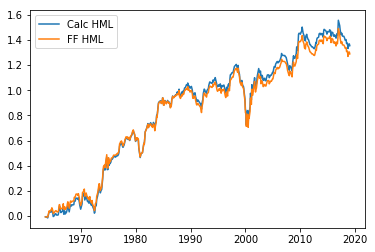

In [51]:
import matplotlib.pyplot as plt
plt.plot(np.log(1+ff_factors['HML']).cumsum(), label ='Calc HML')
plt.plot(np.log(1+ff_factors['HML_t']/100).cumsum(), label ='FF HML')
plt.legend()
plt.show()

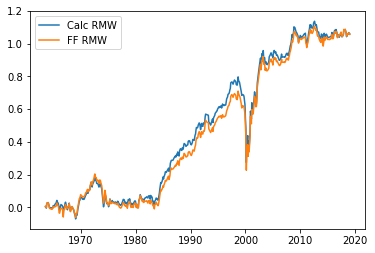

In [85]:
plt.plot(np.log(1+ff_factors['RMW']).cumsum(), label ='Calc RMW')
plt.plot(np.log(1+ff_factors['RMW_t']/100).cumsum(), label ='FF RMW')
plt.legend()
plt.show()

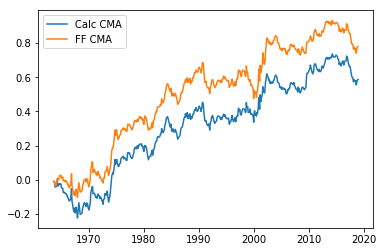

In [53]:
plt.plot(np.log(1+ff_factors['CMA']).cumsum(), label ='Calc CMA')
plt.plot(np.log(1+ff_factors['CMA_t']/100).cumsum(), label ='FF CMA')
plt.legend()

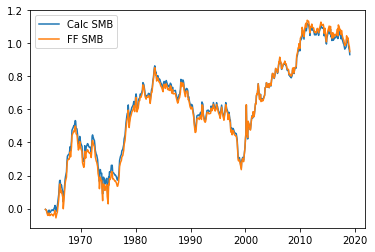

In [88]:
plt.plot(np.log(1+ff_factors['SMB']).cumsum(), label ='Calc SMB')
plt.plot(np.log(1+ff_factors['SMB_t']/100).cumsum(), label ='FF SMB')
plt.legend()


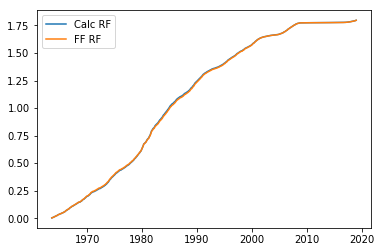

In [62]:
plt.plot(np.log(1+ff_factors['rf']).cumsum(), label ='Calc RF')
plt.plot(np.log(1+ff_factors['RF_t']/100).cumsum(), label ='FF RF')
plt.legend()

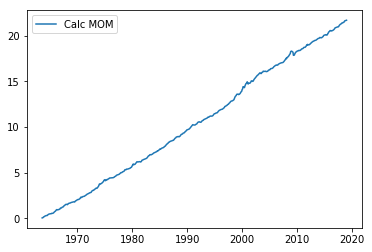

In [68]:
plt.plot(np.log(1+ff_factors['MOM']).cumsum(), label ='Calc MOM')
plt.legend()